<a href="https://colab.research.google.com/github/rahiakela/kaggle-competition-projects/blob/master/song-popularity-prediction/song_popularity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Song Popularity Prediction

MLSpace is happy to present the first competition of the series.
This is a limited competition and everyone is welcome to join. To request invitation link visit MLSpace Discord: https://discord.gg/4RMwz64gdH

In this competition, you are supposed to predict the popularity of a song given features like acousticness, danceability, key, loudness, etc.

**Reference**:

https://www.kaggle.com/c/song-popularity-prediction/overview

##Setup

In [ ]:
!pip -q install  autoxgb

In [19]:
!pip -q install datatable

     |████████████████████████████████| 96.9 MB 127 kB/s 


In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import datatable as dt

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file

In [4]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle> URL: https://www.kaggle.com/c/song-popularity-prediction/data?select=train.csv
kaggle competitions download -c song-popularity-prediction

unzip -qq train.csv.zip
unzip -qq test.csv.zip

kaggle.json
  0% 0.00/3.33M [00:00<?, ?B/s]
100% 3.33M/3.33M [00:00<00:00, 111MB/s]
  0% 0.00/849k [00:00<?, ?B/s]
100% 849k/849k [00:00<00:00, 118MB/s]
  0% 0.00/67.3k [00:00<?, ?B/s]
100% 67.3k/67.3k [00:00<00:00, 69.3MB/s]


##Data Exploration

In [2]:
train_song_df = pd.read_csv("train.csv")
test_song_df = pd.read_csv("test.csv")
ss_df = pd.read_csv("sample_submission.csv")

train_song_df.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [3]:
train_song_df.shape, test_song_df.shape

((40000, 15), (10000, 14))

In [4]:
train_song_df.isna().sum().sum()

32187

In [5]:
test_song_df.isna().sum().sum()

7962

In [6]:
train_song_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,40000.0,19999.500000,11547.149720,0.000000,9999.750000,19999.500000,29999.250000,39999.000000
song_duration_ms,35899.0,193165.847572,45822.127679,25658.000000,166254.500000,186660.000000,215116.000000,491671.000000
acousticness,36008.0,0.276404,0.297928,-0.013551,0.039618,0.140532,0.482499,1.065284
danceability,35974.0,0.570951,0.190010,0.043961,0.424760,0.608234,0.718464,0.957131
energy,36025.0,0.683932,0.212662,-0.001682,0.539276,0.704453,0.870503,1.039741
instrumentalness,36015.0,0.036527,0.150024,-0.004398,0.000941,0.001974,0.003225,1.075415
key,35935.0,5.042605,3.372728,0.000000,2.000000,5.000000,8.000000,11.000000
liveness,35914.0,0.198514,0.151670,0.027843,0.111796,0.135945,0.212842,1.065298
loudness,36043.0,-7.407596,3.877198,-32.117911,-9.578139,-6.345413,-4.620711,-0.877346
audio_mode,40000.0,0.321150,0.466924,0.000000,0.000000,0.000000,1.000000,1.000000


Text(0.5, 1.05, 'Target  distribution')

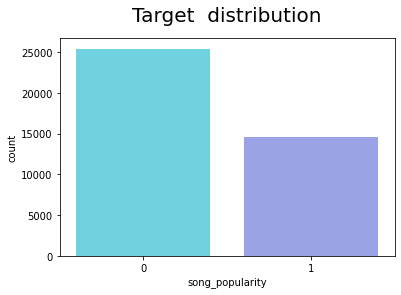

In [7]:
# Lets find traget variable distribution
target_varibale = train_song_df["song_popularity"]

pal = ['#5ddef4','#8e99f3']
plt=sns.countplot(x=train_song_df.song_popularity, palette=pal)
plt.set_title("Target  distribution", fontsize=20, y=1.05)

In [8]:
categorical_features = []
numerical_features = []

for i in train_song_df:
  if train_song_df[i].dtype == "float16":
    numerical_features.append(i)
  elif i != "target":
    categorical_features.append(i)

In [9]:
len(numerical_features)

0

In [10]:
len(categorical_features)

15

In [11]:
df_num_features = pd.concat([train_song_df[numerical_features], train_song_df['song_popularity']], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


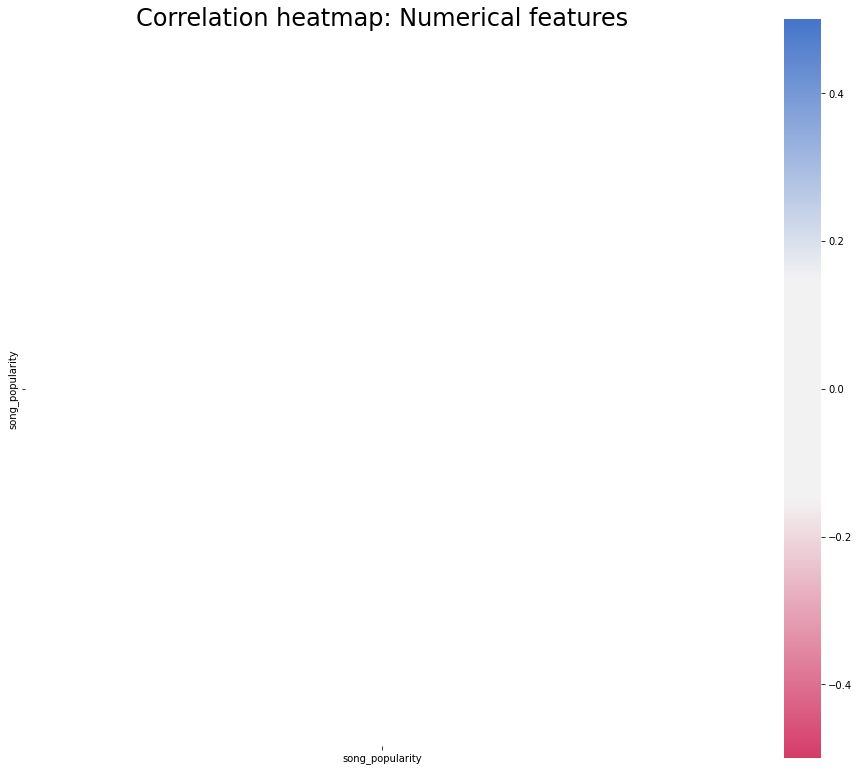

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16 , 16))
corr = df_num_features.sample(10000, random_state=2021).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, ax=ax, square=True, center=0, linewidth=1,
        cmap=sns.diverging_palette(0,255,sep=77, as_cmap=True),vmax=0.5, vmin=-0.5,
        cbar_kws={"shrink": .85}, mask=mask )
ax.set_title('Correlation heatmap: Numerical features', fontsize=24, y= 1.05)
plt.show()

##Feature Engineering using PCA

In [15]:
X = train_song_df.drop("song_popularity", axis=1)
y = train_song_df["song_popularity"]

# In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.fit_transform(X)

##Train AutoXGB model

In [ ]:
!autoxgb train \
    --train_filename train.csv \
    --test_filename test.csv \
    --id IDX \
    --target song_popularity \
    --task classification \
    --num_folds 5 \
    --time_limit 3600 \
    --output OUTPUT \
    --use_gpu

In [18]:
pred_df = pd.read_csv("OUTPUT/test_predictions.csv")

final_class = []
for i in pred_df.iterrows():
  current_class = 1
  if i[1][1] > i[1][2]:
    current_class = 0
    final_class.append(current_class)
  else:
    final_class.append(current_class)

In [19]:
ss_df['song_popularity'] = final_class
ss_df.to_csv('sub.csv', index=False)
ss_df.head()

,id,song_popularity
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [20]:
# submit the file to kaggle
!kaggle competitions submit song-popularity-prediction -f sub.csv -m 'Yeah! I submit my file through the Google Colab!'

100% 67.3k/67.3k [00:02<00:00, 34.1kB/s]
Successfully submitted to Song Popularity Prediction